In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv
import sys
import scipy.constants as const
sys.path.append("..")
import minimise
import energy_utils as energy
# Enable or disable Tensor Float 32 Execution
tf.config.experimental.enable_tensor_float_32_execution(False)

In [ ]:
# --- cDFT global system Parameters ---
dx = 0.02  # spatial step in Angstroms
kappa_inv = 4.5  # inverse screening length
dielectric = 1.0  # dielectric constant
mu_correction = 0.0  # chemical potential correction

# --- Model and Output Paths ---
modelc1_path = "../../models/c1_dipole_Apr30.keras"
modeln1_path = "../../models/n1_dipole_Apr30.keras"

# --- Load Pretrained Models ---
model_c1 = keras.models.load_model(modelc1_path)
model_n1 = keras.models.load_model(modeln1_path)

/home/btb32/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:104: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'rho_A' mapping to value <KerasTensor shape=(None, 1001), dtype=float32, sparse=False, name=rho> which has name 'rho'. Change the tensor name to 'rho_A' (via `Input(..., name='rho_A')`)
  warnings.warn(
/home/btb32/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:104: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'elec' mapping to value <KerasTensor shape=(None, 1001), dtype=float32, sparse=False, name=phi> which has name 'phi'. Change the tensor name to 'elec' (via `Input(..., name='elec')`)
  warnings.warn(


In [ ]:

            
def LJ_wall_93(z_range, z_wall, epsilon, sigma, cutoff, place='lo'):
    """
    Calculate a 9-3 Lennard-Jones wall potential.

    Parameters:
        z_range (np.ndarray): Positions at which to evaluate the potential.
        z_wall (float): Wall location.
        epsilon (float): LJ energy parameter in kT.
        sigma (float): LJ length parameter in Angstroms.
        cutoff (float): Cutoff distance in Angstroms.
        place (str): 'lo' for lower wall, 'hi' for upper wall.

    Returns:
        np.ndarray: Potential energy at each position in z_range.
    """
 
  
    hilo = {'lo': 1.0, 'hi': -1.0}
    z_rel = hilo[place]*(z_range - z_wall)
    
    # Avoid division by zero and negative values in z_rel
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio3 = np.where(z_rel > 0, (sigma / z_rel) ** 3, 0)
        ratio9 = ratio3 ** 3
        energy = epsilon * (ratio9 * 2/15 - ratio3)
        
    # Apply boundary conditions
    energy[z_rel <= 0] = np.inf
    energy[z_rel > cutoff] = 0.0
    
    # Shift the potential to ensure it is zero at the cutoff
    cutoff_energy = epsilon * ((sigma / cutoff) ** 9 * 2./15. - (sigma / cutoff) ** 3)
    energy[z_rel <= cutoff] -= cutoff_energy
    
    return energy
            
def slit_Ewave(mu, amp, zbins, Vext,
               k, L, temp, init_guess, range, write_profile=False):
    """
    Solve the cDFT problem for a slit system under
    an applied sinusoidal electric potential.

    Parameters:
        mu (float): Chemical potential.
        amp (float): Amplitude of applied electric field.
        zbins (np.ndarray): Spatial grid points.
        Vext (np.ndarray): External potential (e.g., wall interactions).
        k (int): Wave number (number of wave peaks across domain).
        L (float): Total domain length.
        temp (float): Temperature in Kelvin.
        rho_guess (np.ndarray): Initial density guess.
    """
    A = 2 * np.pi * k / L
    Phi_field = np.cos(A * zbins) * amp / A
    elec = Phi_field / (
        const.Boltzmann * temp / const.elementary_charge
    )
    
    rho_guess = np.full_like(zbins, init_guess) 

    muloc = -Vext + mu

    if range == 'LR':
       

        zs, rho_DFT, n_DFT, elecR_DFT = minimise.minimise_LR(
            model_c1, model_n1, zbins, muloc, elec, temp,
            kappa_inv, dielectric, mu_correction, dx=dx,
            initial_guess=rho_guess, tolerance=0.013,
            tolerance_restr=0.0002, maxiter=10000,
            plot=True, plot_every=100, print_every=100,
            symmetric=True
        )
    elif range == 'SR':
    
        
        zs, rho_DFT, n_DFT = minimise.minimise_SR(
            model_c1, model_n1, zbins, muloc, elec, temp, dx=dx,
            initial_guess=rho_guess,
            plot=True, plot_every=100, print_every=100,
            symmetric=True
        )
        elecR_DFT = elec

    betaF = energy.get_free_energy(temp, rho_DFT, elec, mu, dx, model_c1, model_n1)
    return zs, rho_DFT, n_DFT, betaF

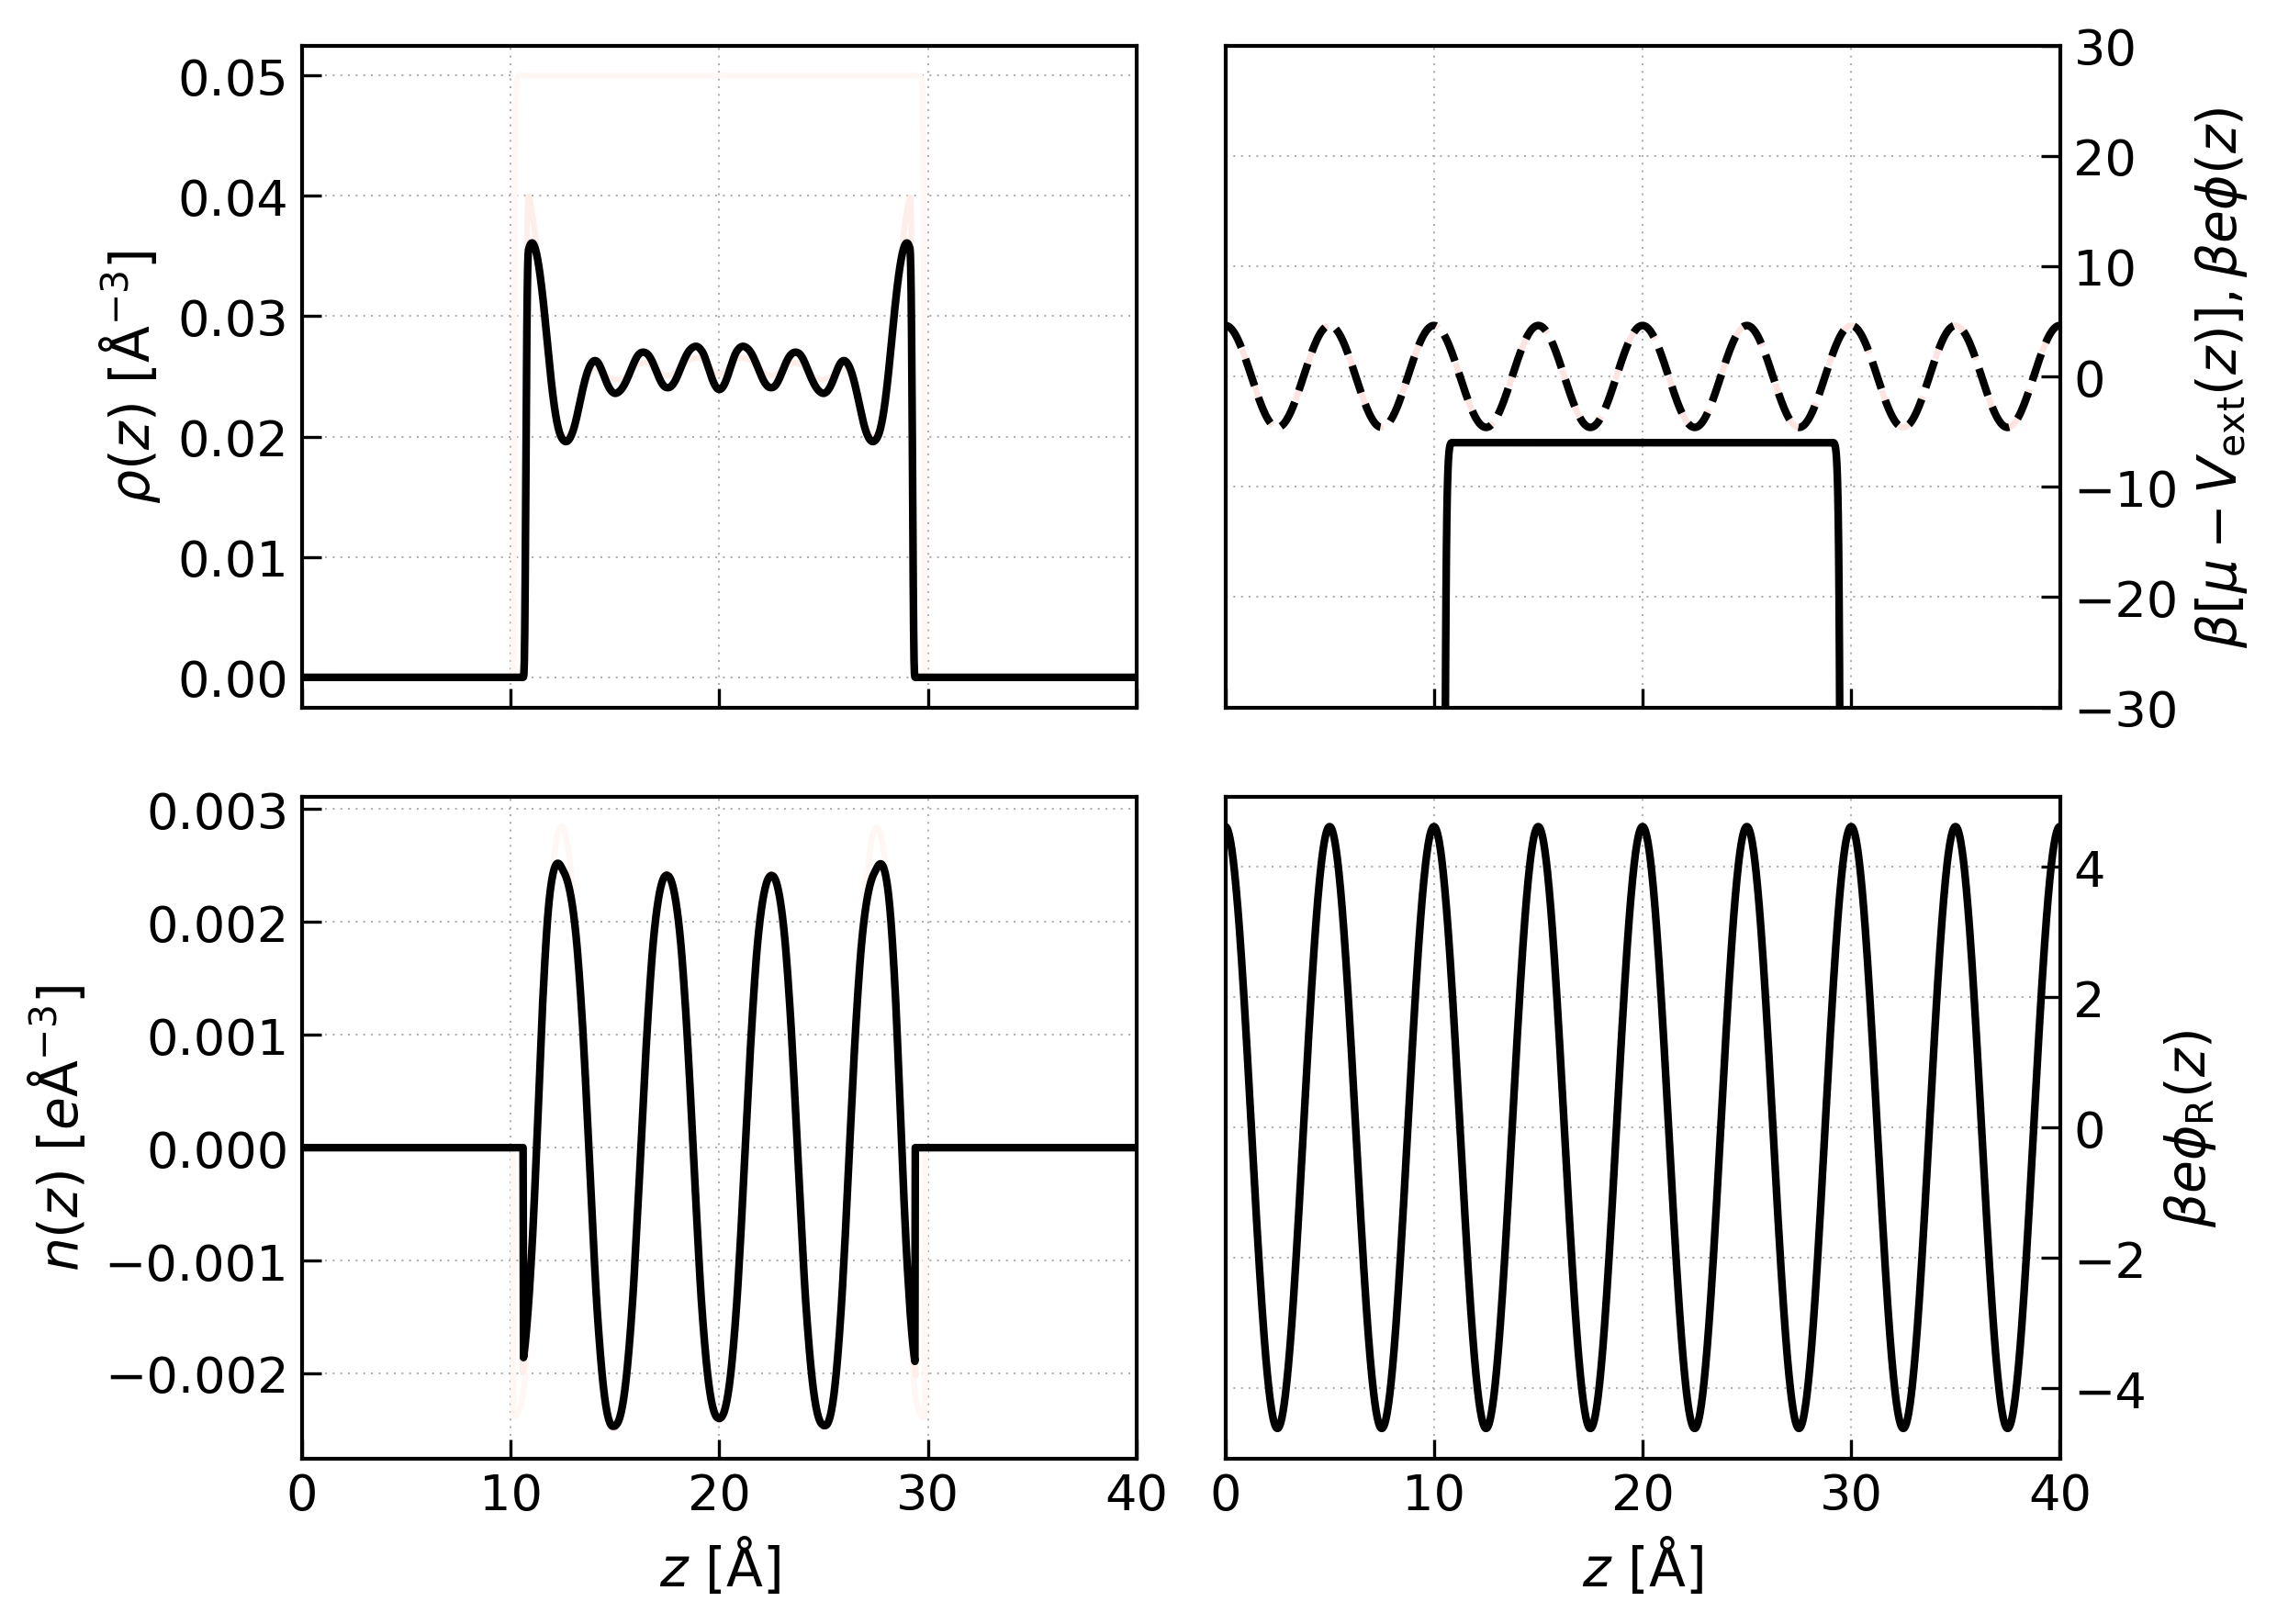

In [8]:
# --- Main cDFT  ---

L = 40  # Domain length in Angstroms
zbins = np.arange(0, L + dx, dx)  # Spatial bins


k = 8  # Wave number (number of wave peaks across domain)

# External wall potentials
V_lo = LJ_wall_93(zbins, 10, 1.0, 1.0, 0.858374218933, 'lo')
V_hi = LJ_wall_93(zbins, 30, 1.0, 1.0, 0.858374218933, 'hi')
Vext = V_lo + V_hi

# Run for different chemical potentials and field amplitudes
mu_range = [-6]
amp_range = [0.2]
for mu in mu_range:
    for amp in amp_range:
        slit_Ewave(mu, amp, zbins, Vext,
                   k, L, temp=400, init_guess=0.05, range='SR')
